Project to  predict city cycle fuel consumption using K Means algorithm

Steps to follow:

1.EDA & Pre-processing (Make sure to remove all non-numeric entries from numeric columns) – 2.5 points
2.Use pair plot or scatter matrix to visualize how the different variables are related (Hint: The amount of Gaussian curves in the plot should give a visual identification of different clusters existing in the dataset) – 5 points
3.Use K Means or Hierarchical clustering to find out the optimal no of clusters in the data. Identify and separate the clusters (15 points)
4.Use linear regression model on different clusters separately and print the coefficients of the models individually (7.5 points)

In [1]:
import warnings 
warnings.filterwarnings('ignore')
# To enable plotting graphs in Jupyter notebook
%matplotlib inline 
# importing ploting libraries
import matplotlib.pyplot as plt   

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
# calculate accuracy measures 
from sklearn import metrics

In [2]:
cars_df = pd.read_csv("cars-dataset.csv")

In [3]:
cars_df.shape

(398, 8)

In [4]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


In [5]:
cars_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6


In [6]:
# car name and hp are missing , hence we need to review them for contents and convert them to numeric

In [7]:
# drop the car name column as it is useless for the model
cars_df = cars_df.drop('car name', axis=1)


In [8]:
#Check if the hp column contains anything other than digits 
# run the "isdigit() check on 'hp' column of the mpg_df dataframe. Result will be True or False for every row
# capture the result in temp dataframe and dow a frequency count using value_counts()
# There are six records with non digit values in 'hp' column
temp = pd.DataFrame(cars_df.hp.str.isdigit())

temp[temp['hp'] == False]

,hp
32,False
126,False
330,False
336,False
354,False
374,False


In [9]:
# On inspecting records number 32, 126 etc, we find "?" in the columns. Replace them with "nan"
#Replace them with nan and remove the records from the data frame that have "nan"
cars_df = cars_df.replace('?', np.nan)

In [10]:
#Let us see if we can get those records with nan

cars_df[cars_df.isnull().any(axis=1)]

,cyl,disp,hp,wt,acc,yr,mpg
32,4,98.0,NaN,2046,19.0,71,25.0
126,6,200.0,NaN,2875,17.0,74,21.0
330,4,85.0,NaN,1835,17.3,80,40.9
336,4,140.0,NaN,2905,14.3,80,23.6
354,4,100.0,NaN,2320,15.8,81,34.5
374,4,151.0,NaN,3035,20.5,82,23.0


In [11]:
# There are various ways to handle missing values. Drop the rows, replace missing values with median values etc. 
#of the 398 rows 6 have NAN in the hp column. We will drop those 6 rows. Not a good idea under all situations
#note: HP is missing becauses of the non-numeric values in the column. 
#cars_df = cars_df.dropna()

In [12]:
#instead of dropping the rows, lets replace the missing values with median value. 
cars_df.median()

cyl        4.0
disp     148.5
hp        93.5
wt      2803.5
acc       15.5
yr        76.0
mpg       23.0
dtype: float64

In [13]:
# replace the missing values in 'hp' with median value of 'hp' :Note, we do not need to specify the column names
# every column's missing value is replaced with that column's median respectively
cars_df = cars_df.fillna(cars_df.median())

In [14]:
# preprocessing to convert the 2 object type columns to numeric.
cars_df['hp'] = pd.to_numeric(cars_df['hp'])

In [15]:
cars_df.describe().transpose()
mpg_df = cars_df.copy(deep = True)

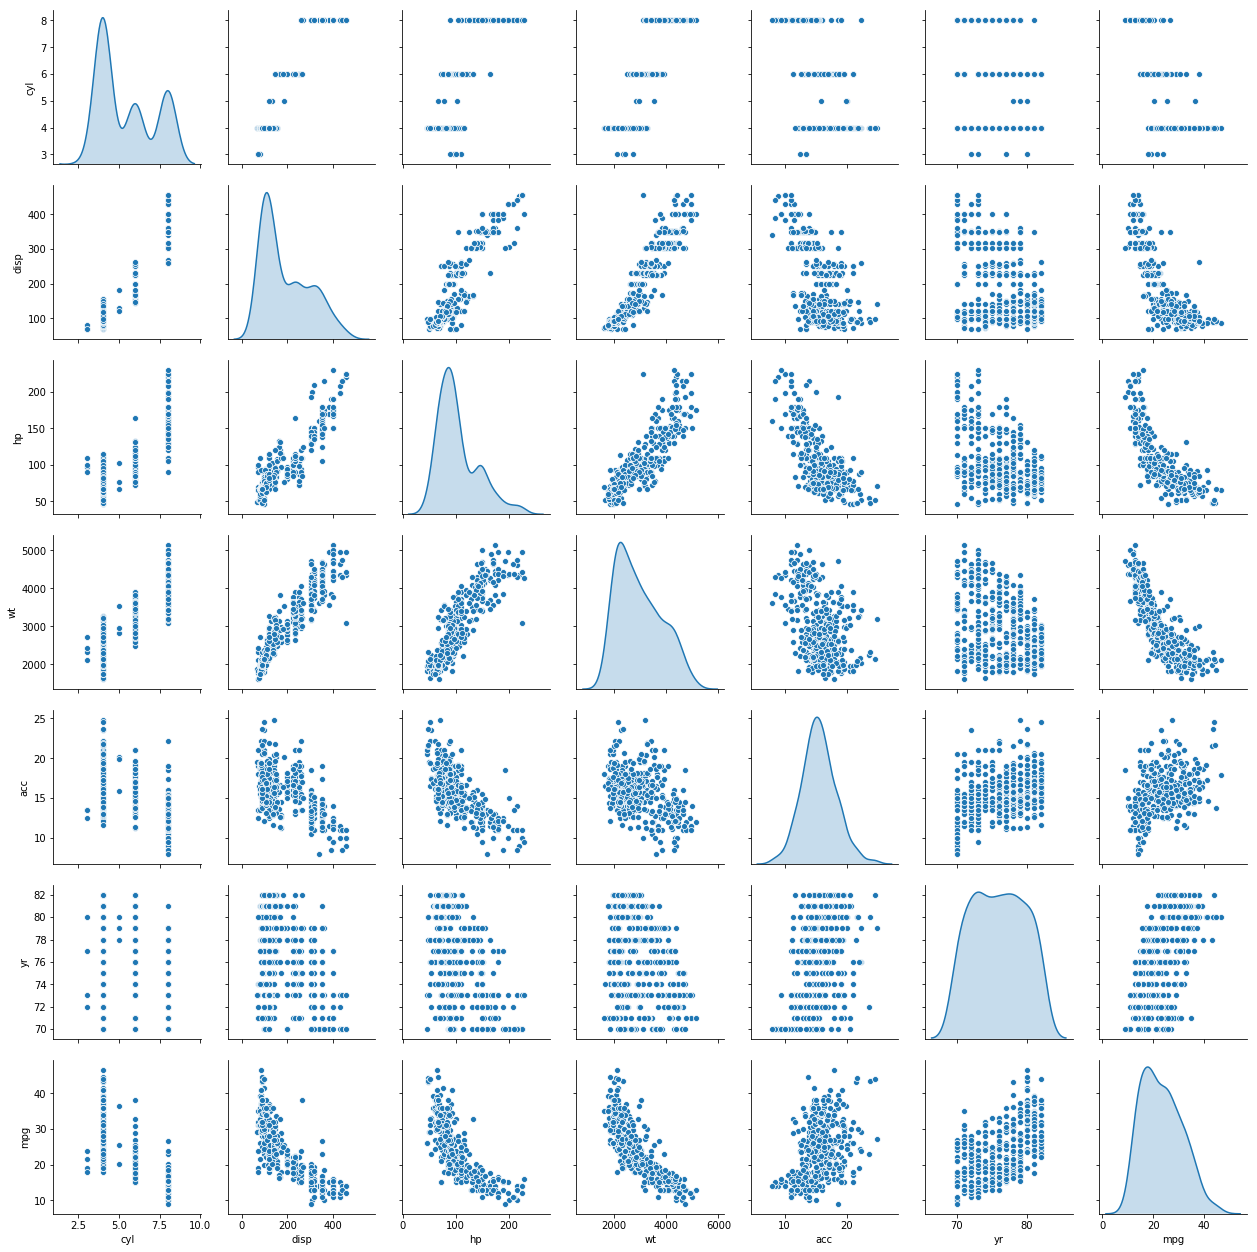

In [16]:
sns.pairplot(cars_df, diag_kind='kde')

we can assume about 3 to 6 clusters, let's run the algorithm to find the ideal one

Attribute relationships:
    1. Disp & wt varies depending on the number of cylinders- less cylinders , lesser the displacement, weight
    2. Disp is positively co-related with hp and wt: negatively with acc & mpg.
    3. The 3 peak disp distribution matches with the 3 cylinders level: as we saw in the cyl v/s disp graph
    4. hp has 3 peaks, one is very small.
    5. hp and wt are positively co-related, negative co-related to acc and mpg
    6. wt has a non normal distributon with hidden/ overlapping peaks.
    7. wt and mpg are negatively co-related
    8. acc seems to follow a normal distribution, however the peaks could be hidden in the dimenion.
    9. yr  data can be removed , it follow on trend and provides no insights
    10. mpg peaks are hidden in the distribution

In [17]:
from scipy.stats import zscore
cars_df_z = cars_df.apply(zscore) # to bring all attributes on same scale.

In [18]:
cluster_range = range( 1, 10)   # expect 3 to four clusters from the pair panel visual inspection hence restricting from 2 to 6
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 5)
  clusters.fit(cars_df_z)
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:15]

,num_clusters,cluster_errors
0,1,2786.000000
1,2,1294.841895
2,3,946.019791
3,4,738.374388
4,5,665.774875
5,6,603.564742
6,7,546.255839
7,8,496.400651
8,9,469.748405


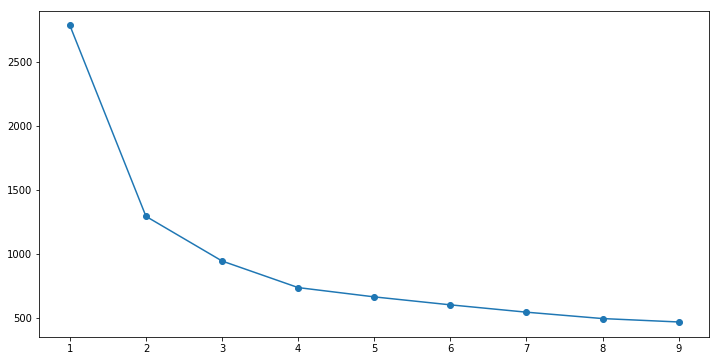

In [19]:
# Elbow plot

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [20]:
# The elbow plot confirms our visual analysis that there are likely 3 or 2 good clusters
# Let us start with 3 clusters

In [21]:
cluster = KMeans( n_clusters = 3, random_state = 2354 )
cluster.fit(cars_df_z)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=2354, tol=0.0001, verbose=0)

In [22]:
centroids = cluster.cluster_centers_
centroids

array([[-0.85347696, -0.80321374, -0.67506194, -0.78549879,  0.36133415,
         0.30992304,  0.75394661],
       [ 1.49819126,  1.50068407,  1.51412926,  1.40001604, -1.07612225,
        -0.6725559 , -1.15871315],
       [ 0.35772459,  0.24687769, -0.04275477,  0.30829922,  0.28578589,
        -0.00272145, -0.47905415]])

In [23]:
centroid_df = pd.DataFrame(centroids, columns = list(cars_df_z) )
centroid_df

,cyl,disp,hp,wt,acc,yr,mpg
0,-0.853477,-0.803214,-0.675062,-0.785499,0.361334,0.309923,0.753947
1,1.498191,1.500684,1.514129,1.400016,-1.076122,-0.672556,-1.158713
2,0.357725,0.246878,-0.042755,0.308299,0.285786,-0.002721,-0.479054


In [24]:
prediction=cluster.predict(cars_df_z)
cars_df_z["GROUP"] = prediction     # Creating a new column "GROUP" which will hold the cluster id of each record

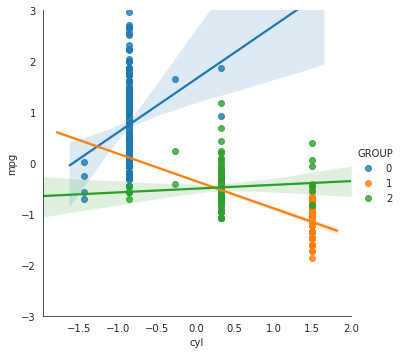

In [25]:
var = 'cyl'

with sns.axes_style("white"):
    plot = sns.lmplot(var,'mpg',data=cars_df_z,hue='GROUP')
plot.set(ylim = (-3,3))

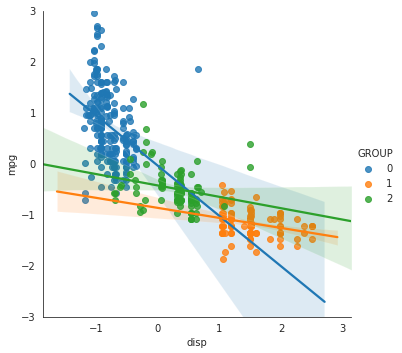

In [26]:
var = 'disp'

with sns.axes_style("white"):
    plot = sns.lmplot(var,'mpg',data=cars_df_z,hue='GROUP')
plot.set(ylim = (-3,3))

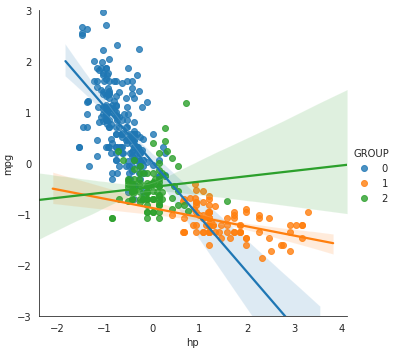

In [27]:
var = 'hp'

with sns.axes_style("white"):
    plot = sns.lmplot(var,'mpg',data=cars_df_z,hue='GROUP')
plot.set(ylim = (-3,3))

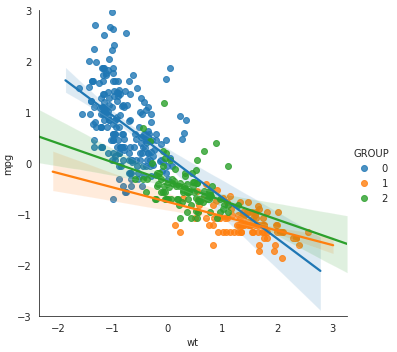

In [28]:
var = 'wt'

with sns.axes_style("white"):
    plot = sns.lmplot(var,'mpg',data=cars_df_z,hue='GROUP')
plot.set(ylim = (-3,3))

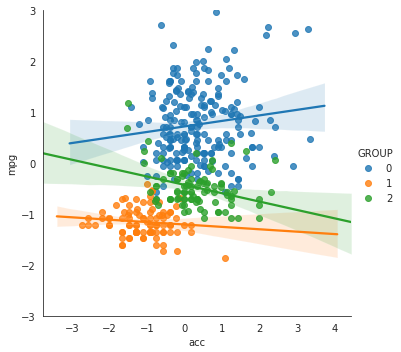

In [29]:
var = 'acc'

with sns.axes_style("white"):
    plot = sns.lmplot(var,'mpg',data=cars_df_z,hue='GROUP')
plot.set(ylim = (-3,3))

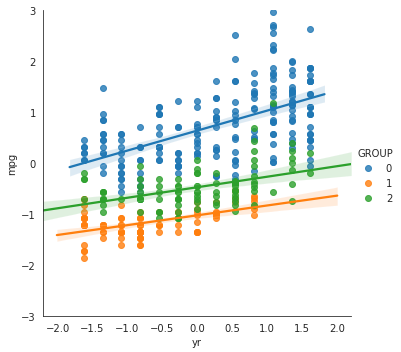

In [30]:
var = 'yr'

with sns.axes_style("white"):
    plot = sns.lmplot(var,'mpg',data=cars_df_z,hue='GROUP')
plot.set(ylim = (-3,3))

In [31]:
# drop the year col
# drop the yr column as it is useless for the model
cars_df_z1 = cars_df_z.drop('yr', axis=1)

# separate the dataset by clusters
cars_df_z_0 = cars_df_z1[cars_df_z1["GROUP"] == 0]
cars_df_z_1 = cars_df_z1[cars_df_z1["GROUP"] == 1]
cars_df_z_2 = cars_df_z1[cars_df_z1["GROUP"] == 2]
cars_df_z_0.shape
cars_df_z_1.shape
cars_df_z_2.shape
cars_df_z_2.head()

,cyl,disp,hp,wt,acc,mpg,GROUP
15,0.320935,0.043923,-0.243723,-0.162483,-0.024722,-0.194023,2
16,0.320935,0.053526,-0.191332,-0.232242,-0.024722,-0.706439,2
17,0.320935,0.063128,-0.505677,-0.453340,0.156817,-0.322127,2
24,0.320935,0.053526,-0.374700,-0.381217,-0.206262,-0.322127,2
33,0.320935,0.370411,-0.112746,-0.397770,-0.932419,-0.578335,2


In [32]:
# Addressing outliers at group level

#data = mpg_df_attr_z   # lazy to type long names. Renaming it to data. Remember data is not a copy of the dataframe
       
def replace(group):
    median, std = group.median(), group.std()  #Get the median and the standard deviation of every group 
    outliers = (group - median).abs() > 2*std # Subtract median from every member of each group. Take absolute values > 2std
    group[outliers] = group.median() # replacing group outliers with group median      
    return group

#data_corrected = (data.groupby('GROUP').transform(replace)) 
#concat_data = data_corrected.join(pd.DataFrame(mpg_df_attr_z['GROUP']))

In [33]:

z0 = cars_df_z_0.transform(replace)

In [34]:
def createRegressionModel(df):
    y= df['mpg']
    x1 = df.drop('mpg', axis=1)
    x = x1.drop('GROUP', axis=1)
    print(x.shape)
    
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree = 2, interaction_only=True)

    X_poly = poly.fit_transform(x)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.30, random_state=1)
    reg = LinearRegression()

    reg.fit(X_train, y_train)

    #print(reg.score(X_train, y_train))
    reg_score = reg.score(X_test, y_test)
    return reg_score , reg.coef_, reg.intercept_ 

In [35]:
# Model for entire group

score,coef,intercept = createRegressionModel(cars_df_z1)
print(score,coef,intercept)

(398, 5)
0.7866086864869327 [ 0.          0.13314016 -0.47236902 -0.66144252 -0.19031124 -0.12688458
 -0.15872078  0.58033169 -0.11724545  0.26161372 -0.02582839  0.30662239
 -0.12565269 -0.22646039 -0.09682454 -0.01798961] -0.31716229602781815


In [36]:
# Model for group 0

score_0,coef_0,intercept_0 = createRegressionModel(cars_df_z_0)
print(score_0,coef_0,intercept_0)

(207, 5)
0.2610895610747148 [ 0.00000000e+00  9.35912071e+09  1.30589144e+09 -8.72040186e+08
  6.00471273e+08  2.77130968e+07  1.52500300e+09 -1.01835716e+09
  7.01222526e+08  3.23629938e+07 -8.77449925e-01 -5.40799973e-01
 -8.99683040e-01  1.09321154e+00 -6.94452346e-03  2.51410900e-01] 8014407587.029331


In [37]:
# Model for group 1

score_1,coef_1,intercept_1 = createRegressionModel(cars_df_z_1)
print(score_1,coef_1,intercept_1)

(95, 5)
0.10326726441959633 [ 0.00000000e+00 -5.61979707e+10  1.50775201e+10  1.79621355e+10
  6.66646598e+09 -2.64105547e+09 -1.00638153e+10 -1.19892139e+10
 -4.44967620e+09  1.76282932e+09  2.25908826e-01 -2.18160603e-01
  6.47614593e-02  1.17431376e-01  3.00220317e-02 -1.49534172e-01] 84195308409.37076


In [39]:
# Model for group 2

score_2,coef_2,intercept_2 = createRegressionModel(cars_df_z_2)
print(score_2,coef_2,intercept_2)

(96, 5)
0.2728319653391128 [ 0.          0.48210776 -0.53649239 -0.27915683 -0.08805851 -0.2735944
  0.16946204  0.62731144 -0.69991133  0.22408362  0.82140987  0.20025483
  0.19657722 -0.65132965 -0.25174973  0.11568672] -0.5069164654609606


In [40]:
# let us to Hierarchial clustering

In [41]:
from sklearn.cluster import AgglomerativeClustering 

In [42]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='ward')

In [43]:
mpg_df_z = mpg_df.apply(zscore)
mpg_df_z = mpg_df_z.drop("yr", axis = 1)

model.fit(mpg_df_z)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=3,
            pooling_func='deprecated')

In [44]:
mpg_df_z['labels'] = model.labels_

mpg_df_z.groupby(["labels"]).count()

,cyl,disp,hp,wt,acc,mpg
labels,,,,,,
0,219,219,219,219,219,219
1,99,99,99,99,99,99
2,80,80,80,80,80,80


In [45]:
mpg_clusters = mpg_df_z.groupby(['labels'])

In [46]:
mpg_groups=mpg_clusters.head(398)#This creates a pandas dataframegroupby object

In [47]:
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage

In [48]:
from scipy.spatial.distance import pdist  #Pairwise distribution between data points

In [49]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(mpg_df_z, 'average')
c, coph_dists = cophenet(Z , pdist(mpg_df_z))

c

0.8119127188520682

In [50]:
Z.shape

Z[1]
Z[1:10]

array([[1.81000000e+02, 1.98000000e+02, 3.63078897e-02, 2.00000000e+00],
       [3.40000000e+02, 3.88000000e+02, 6.07220097e-02, 2.00000000e+00],
       [1.75000000e+02, 1.97000000e+02, 7.26157793e-02, 2.00000000e+00],
       [2.66000000e+02, 2.79000000e+02, 7.73310756e-02, 2.00000000e+00],
       [1.76000000e+02, 2.57000000e+02, 8.88827872e-02, 2.00000000e+00],
       [1.40000000e+01, 2.73000000e+02, 9.52316515e-02, 2.00000000e+00],
       [3.53000000e+02, 3.55000000e+02, 1.22182132e-01, 2.00000000e+00],
       [3.37000000e+02, 3.56000000e+02, 1.28738692e-01, 2.00000000e+00],
       [1.27000000e+02, 1.69000000e+02, 1.29022788e-01, 2.00000000e+00]])

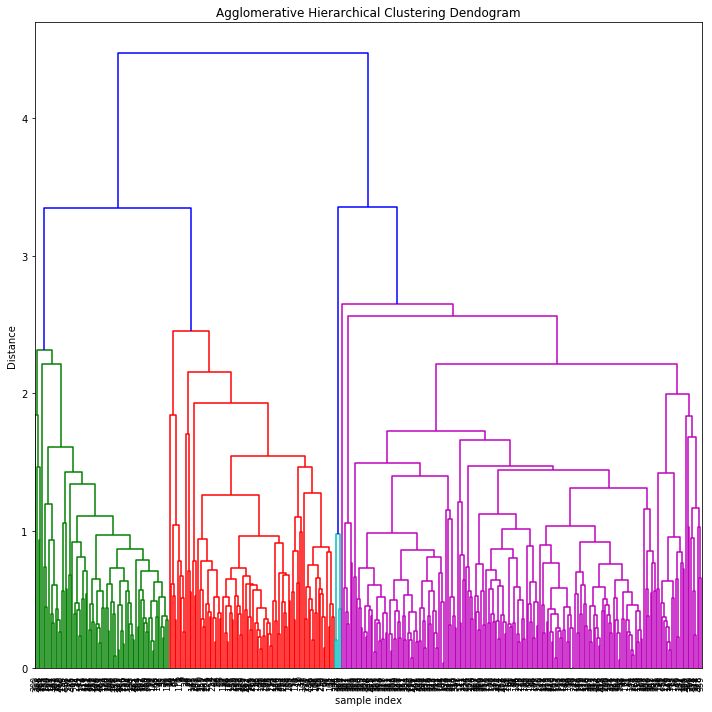

In [51]:
plt.figure(figsize=(10, 10))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 3, leaf_font_size=8. )
plt.tight_layout()

In [52]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(mpg_df_z, 'complete')
c, coph_dists = cophenet(Z , pdist(mpg_df_z))

c

0.8145596931400151

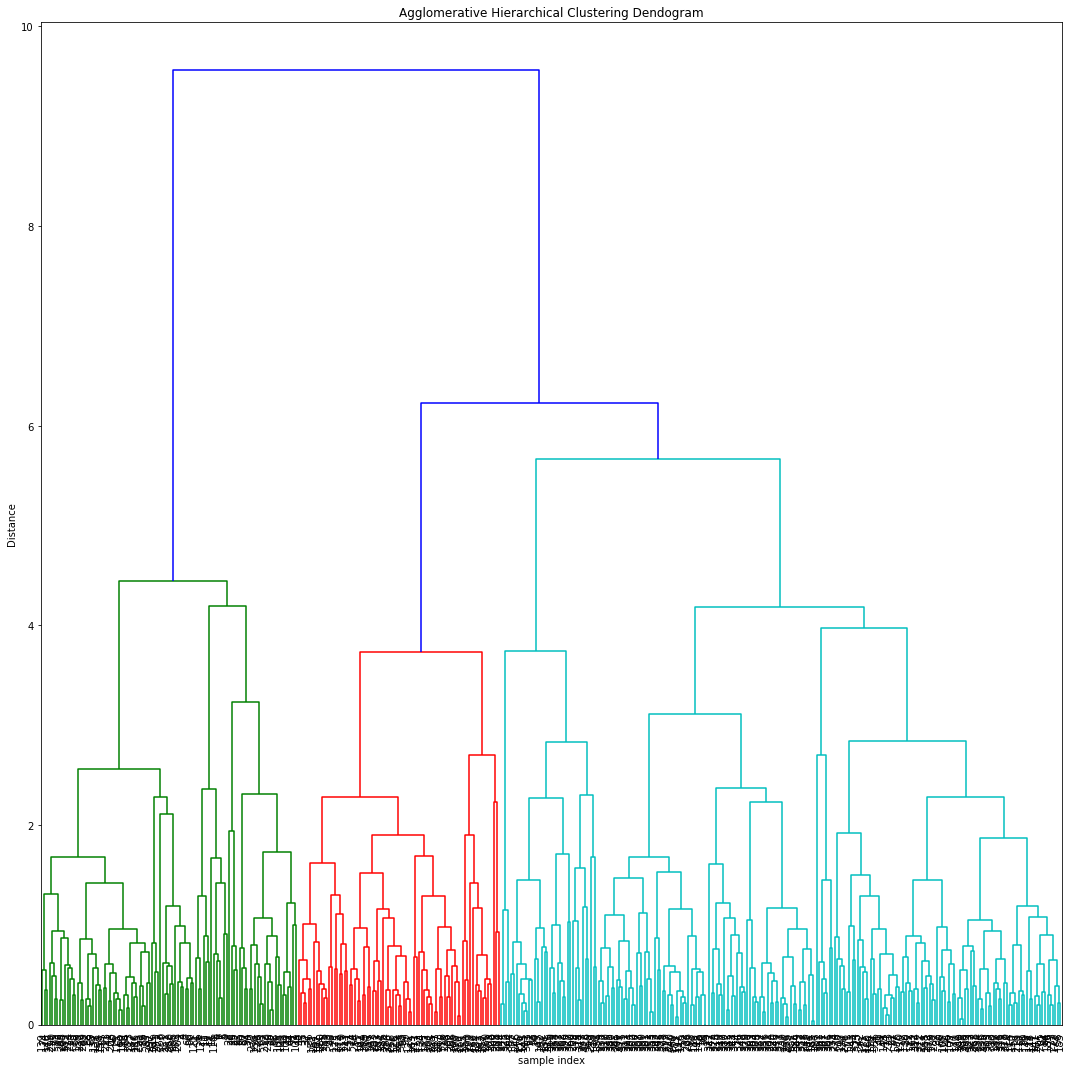

In [53]:
plt.figure(figsize=(15, 15))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold=6,  leaf_font_size=10. )
plt.tight_layout()

In [54]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(mpg_df_z, 'ward')
c, coph_dists = cophenet(Z , pdist(mpg_df_z))

c

0.7888667175755784

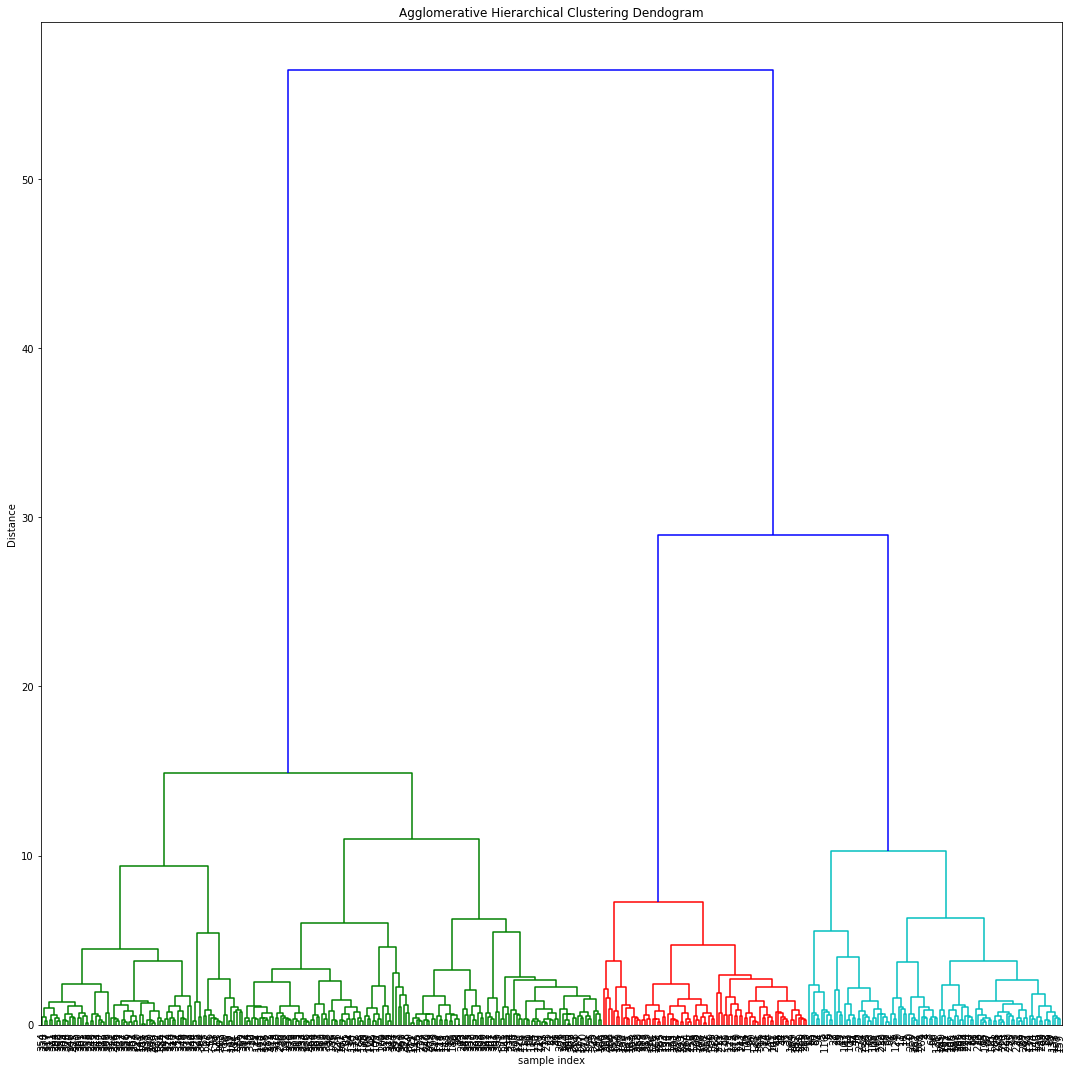

In [55]:
plt.figure(figsize=(15, 15))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold=20,  leaf_font_size=10. )
plt.tight_layout()

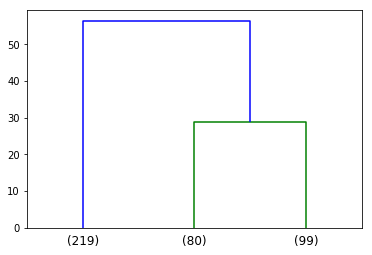

In [56]:
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=3,  # show only the last p merged clusters
)
plt.show()

In [57]:
mpg_df_z.sample()

,cyl,disp,hp,wt,acc,mpg,labels
325,-0.856321,-0.993154,-1.474909,-1.046877,2.226367,2.662696,0


In [58]:
mpg_df_z_0 = mpg_df_z[mpg_df_z["labels"] == 0]
mpg_df_z_1 = mpg_df_z[mpg_df_z["labels"] == 1]
mpg_df_z_2 = mpg_df_z[mpg_df_z["labels"] == 2]

In [59]:
def createRegressionModel_mpg(df):
    y= df['mpg']
    x1 = df.drop('mpg', axis=1)
    x = x1.drop('labels', axis=1)
    print(x.shape)
    
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree = 2, interaction_only=True)

    X_poly = poly.fit_transform(x)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.30, random_state=1)
    reg = LinearRegression()

    reg.fit(X_train, y_train)

    #print(reg.score(X_train, y_train))
    reg_score = reg.score(X_test, y_test)
    return reg_score , reg.coef_, reg.intercept_ 

In [60]:
# Model for group 0

score_0,coef_0,intercept_0 = createRegressionModel_mpg(mpg_df_z_0)
print(score_0,coef_0,intercept_0)

(219, 5)
0.2765603710416076 [ 0.         -0.12568712  1.8309781  -1.20907821 -1.67937212 -0.27993093
  0.72939895 -0.86469234 -2.03438146  0.40554062  1.31369783  1.13095953
 -0.77896441 -0.93748298 -0.05550141  0.25100448] 0.3996526779538956


In [61]:
# Model for group 1

score_1,coef_1,intercept_1 = createRegressionModel_mpg(mpg_df_z_1)
print(score_1,coef_1,intercept_1)

(99, 5)
0.4223646703495666 [ 0.00000000e+00 -3.29504451e+11  9.35989078e+10  9.17639172e+10
 -1.59018300e+10 -1.03976399e+11 -6.24746055e+10 -6.12498015e+10
  1.06140187e+10  6.94012853e+10  1.97781973e-01 -1.96145286e-01
  7.76346017e-02  3.13629036e-02 -4.17636498e-02 -2.01735256e-01] 493660688133.4523


In [62]:
# Model for group 2

score_2,coef_2,intercept_2 = createRegressionModel_mpg(mpg_df_z_2)
print(score_2,coef_2,intercept_2)

(80, 5)
-0.1417305909342046 [ 0.         -0.24102207 -1.15292165  1.02093174 -0.52302463  0.59685478
  1.84542232 -2.22404631  0.03024954 -0.302285    0.38564406  0.57639484
 -0.99956473 -0.76230067  0.01365831 -0.03464945] -0.23868097095728197


In [63]:
# Model for entire group 

score,coef,intercept = createRegressionModel_mpg(mpg_df_z)
print(score,coef,intercept)

(398, 5)
0.7866086864869327 [ 0.          0.13314016 -0.47236902 -0.66144252 -0.19031124 -0.12688458
 -0.15872078  0.58033169 -0.11724545  0.26161372 -0.02582839  0.30662239
 -0.12565269 -0.22646039 -0.09682454 -0.01798961] -0.31716229602781815


In [ ]:
# linear regression on the complete set is a better prepictor than the individual clusters in this case - KMeans or Agglomerative
# It could be that in order to improve accuracy we need much more data points in each cluster for training. DUe to inefficency in data 
# we cannot use the cluster-level regression models in production as they are poor predictor s of mpg. 
# additionally,We observed that even after removing outliers the cluster level accuracy did not improve; rather it deterioated.